In [ ]:
!gdown 17jfPpVRdy2agjZTkIZ64LXGyzc54WICB

# https://drive.google.com/file/d/17jfPpVRdy2agjZTkIZ64LXGyzc54WICB/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=17jfPpVRdy2agjZTkIZ64LXGyzc54WICB
To: /content/StyleTransfer_Data.zip
100% 1.85M/1.85M [00:00<00:00, 205MB/s]


In [ ]:
!unzip -u 'StyleTransfer_Data.zip' -d '/content/'

Archive:  StyleTransfer_Data.zip
  inflating: /content/City.jpg       
  inflating: /content/__MACOSX/._City.jpg  
  inflating: /content/Persepolis.jpg  
  inflating: /content/__MACOSX/._Persepolis.jpg  
  inflating: /content/Persepolis2.jpg  
  inflating: /content/__MACOSX/._Persepolis2.jpg  
  inflating: /content/Persepolis3.jpg  
  inflating: /content/__MACOSX/._Persepolis3.jpg  
  inflating: /content/Persepolis4.jpg  
  inflating: /content/__MACOSX/._Persepolis4.jpg  
  inflating: /content/StarryNight.jpg  
  inflating: /content/__MACOSX/._StarryNight.jpg  


In [ ]:
!nvidia-smi

In [ ]:
%matplotlib inline
import torch
import torch.optim as optim # to use atom optimizer
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape
    
  in_transform = transforms.Compose([
      transforms.Resize(size), # the ReSize command maintains the aspect scale of the image 
      transforms.ToTensor(), # convert our image to a tensor!
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  image = in_transform(image).unsqueeze(0) # to add an extra layer of dimentianality to the image
  return image

In [ ]:
# content = load_image('City.jpg').to(device)
# content = load_image('Persepolis.jpg').to(device)
content = load_image('Persepolis4.jpg').to(device)
style = load_image('StarryNight.jpg', shape=content.shape[-2:]).to(device)
# style = load_image('Persepolis.jpg', shape=content.shape[-2:]).to(device)

In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 611.5, 399.5, -0.5)

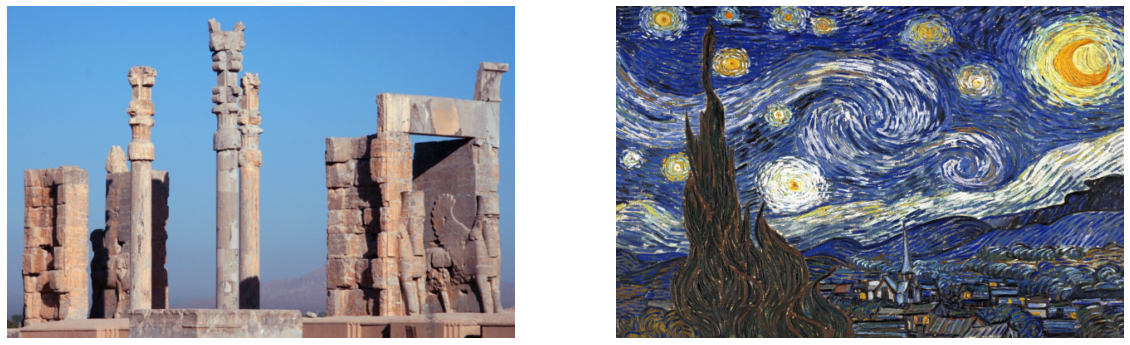

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off') # view image more clearly ...
ax2.imshow(im_convert(style))
ax2.axis('off')

In [ ]:
def get_features(image, model):
  layers = {'0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # content extraction
            '28': 'conv5_1'}

  features = {}

  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features


In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [ ]:
# Gram Matrix = V^T * v
def gram_matrix(tensor):
  _, d, h, w = tensor.size() # TO unwrap the matrix :=> tensor.size()
  tensor = tensor.view(d, h*w) # we can reshape our tensor, we will maintain d as the variable depth (defines the number of feature channels in our tensor)
  gram = torch.mm(tensor, tensor.t()) # to multiply two matrix together!
  # tensor.t() is the transpose form of the tensor
  return gram


In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [ ]:
style_weights = {
    'conv1_1': 1.,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}


content_weight = 1 # alpha
style_weight = 1e6 # beta => 10^(-6)


In [ ]:
target = content.clone().requires_grad_(True).to(device)

In [ ]:
show_every = 300 # update of image after 300 iterations
optimizer = optim.Adam([target], lr=0.003)
steps = 30000
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0


In [ ]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if ii % show_every == 0:
        print("Total loss: ", total_loss.item())
        print("Iteration: ", ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()


    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

(-0.5, 611.5, 399.5, -0.5)

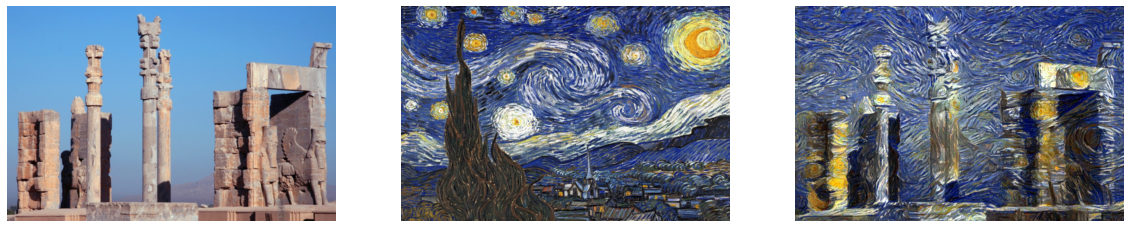

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

# 🔶 **Save Results as Video:**

In [ ]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)

vid.release()

In [ ]:
!ls

In [ ]:
from google.colab import files
files.download('output.mp4')